Value of k: 5
Centroids: 
[[0.         0.42560572 0.32478179 0.10722724 0.42112491 0.18691497
  0.08978442 0.125231  ]
 [2.         0.64044056 0.50385315 0.17553846 1.38313986 0.6144993
  0.29968042 0.38283077]
 [2.         0.49191502 0.38252463 0.13017857 0.6471564  0.27333744
  0.14160037 0.19331897]
 [1.         0.51514329 0.40224736 0.13970588 0.70851508 0.2961267
  0.15716063 0.21150226]
 [0.98021309 0.64496195 0.50862253 0.17704718 1.39617275 0.60090487
  0.30664612 0.39587443]]
Davies Bouldin Index:  0.6485448222501178


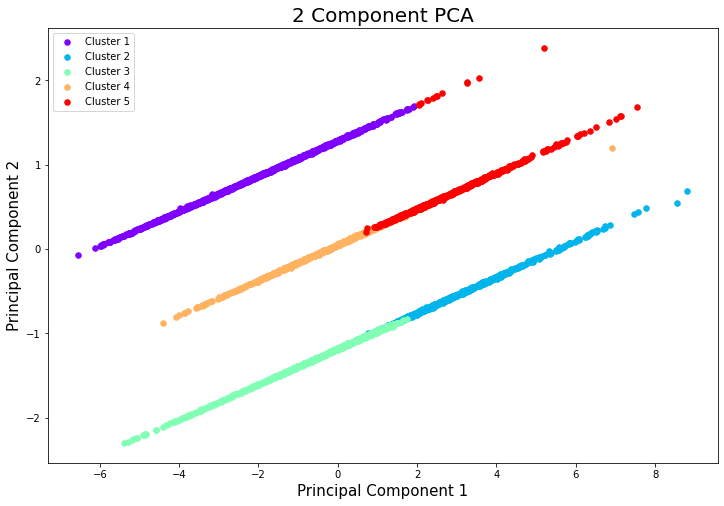

In [1]:
import csv
import numpy as np
from numpy import random
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm
%matplotlib inline


# function to read dataset from file
def readDataset():
    dataset = pd.read_csv('abalone.data', sep=",").to_numpy()
    dataset = np.where(dataset == 'I', 0, dataset)
    dataset = np.where(dataset == 'F', 1, dataset)
    dataset = np.where(dataset == 'M', 2, dataset)
    dataset = dataset[:, 0:8]
    return dataset


# function to find indexes of data which is closest to any of the centroid
def findIndexesWithCentroids(dataset, centroids):
    k = centroids.shape[0]
    indexes = np.zeros(dataset.shape[0])
    for i in range(dataset.shape[0]):
        min_distance = math.inf
        for j in range(k):
            distance = np.sqrt(np.sum((dataset[i,:] - centroids[j,:]) ** 2))
            if distance < min_distance:
                min_distance = distance
                indexes[i] = j
    return indexes


# function to update centroids
def updateCentroids(dataset, indexes, k):
    updated_centroids = np.zeros((k, dataset.shape[1]))
    for i in range(k):
        positions = np.where(indexes == i)
        updated_centroids[i,:] = (np.sum(dataset[positions,:], axis=1) / len(positions[0])).ravel()
    return updated_centroids        


# function to run k-means algorithm
def k_means(dataset, random_centroids, totalIterations):
    k = random_centroids.shape[0]
    indexes = np.zeros(dataset.shape[0])
    updated_centroids = np.copy(random_centroids)
    
    for i in range(totalIterations):
        indexes = findIndexesWithCentroids(dataset, updated_centroids)
        centroids_copy = np.copy(updated_centroids)
        updated_centroids = updateCentroids(dataset, indexes, k)
        if (centroids_copy == updated_centroids).all():
            break
    return indexes, updated_centroids


# function to get random centroids in the start
def getRandomCentroids(dataset, k):
    random_centroids = np.zeros((k, dataset.shape[1]))
    partition_ratio = dataset.shape[0]//k
    partition_value = 0
    for i in range(k):
        random_centroids[i,:] = dataset[random.randint(partition_value, partition_value + partition_ratio)]
        partition_value = partition_value + partition_ratio
    return random_centroids
        
    
# function to plot clusters
def plotData(dataset, indexes):
    # setting figure
    fig, ax = plt.subplots(figsize=(12,8))
    colors = cm.rainbow(np.linspace(0, 1, k))
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    
    # standardising the data and calculating pca
    PCA_dataset = np.copy(dataset)
    standardised_data = StandardScaler().fit_transform(PCA_dataset)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(standardised_data)
    
    # plotting the clusters
    for i in range(k):
        cluster = principalComponents[np.where(indexes == i)[0], :]
        ax.scatter(cluster[:,0], cluster[:,1], s=30, color=colors[i], label=('Cluster ' + str(i + 1)))
    ax.legend()


# function to find euclidean distance
def findEuclideanDistance(row1,row2):
    dist = 0
    for i in range(len(row1)):
        dist += pow((row1[i] - row2[i]), 2)
    return math.sqrt(dist)
    
    
# function to find davies bouldin index
def findDaviesBouldin(dataset, indexes, centroids, k):
    clusters_data = [dataset[indexes == k] for k in range(k)]
    Ri = []
    
    # calculating variances
    variances = [np.mean([findEuclideanDistance(p, centroids[i]) for p in j]) for i, j in enumerate(clusters_data)]

    for i in range(k):
        Rij = []
        for j in range(k):
            if j != i:
                valueForRij = (variances[i] + variances[j]) / findEuclideanDistance(centroids[i], centroids[j])
                Rij.append(valueForRij)
        Ri.append(max(Rij)) 

    # finding mean of all Ri values    
    dbi_value = np.mean(Ri)
    return dbi_value    
    

# main function
if __name__ == "__main__":
    k = 5   # total number of clusters 
    dataset = readDataset()
    random_centroids = getRandomCentroids(dataset, k)
    indexes, centroids = k_means(dataset, random_centroids, 100)
    plotData(dataset, indexes)
    print("Value of k: " + repr(k))
    print("Centroids: ")
    print(centroids)
    print("Davies Bouldin Index: ", findDaviesBouldin(dataset, indexes, centroids, k))
